In [64]:
# ===========================
# IMPORT LIBRARIES
# ===========================

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

In [65]:
# ===========================
# LOAD DATASET
# ===========================

df = pd.read_csv("balanceddata.csv")

print("Shape:", df.shape)
df.head()

Shape: (1061, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,204,2,2,60,316,30,30,30.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,80,3,2,0,0,0,0,0,0.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
2,80,63163100,7,0,0,0,0,0,0.0,0.000000,...,40,7011869.0,0.0,7011869,7011869,18700000.0,12300000.0,32100000,8023736,DoS Slowhttptest
3,21,270,2,1,14,0,14,0,7.0,9.899495,...,32,0.0,0.0,0,0,0.0,0.0,0,0,FTP-Patator
4,1782,57,1,1,2,6,2,2,2.0,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan


In [67]:
# ===========================
# CREATE BINARY + ATTACK TYPE LABELS
# ===========================

# Keep original attack type
df["AttackType"] = df[" Label"]   # preserve string classes

# Create binary label: BENIGN = 0, all others = 1
df["BinaryLabel"] = df[" Label"].apply(lambda x: 0 if x.strip() == "BENIGN" else 1)

In [68]:
# ===========================
# ENCODE ATTACK TYPE ONLY
# ===========================

# LabelEncoder ONLY for multiclass attack type
attack_encoder = LabelEncoder()
df["AttackTypeEncoded"] = attack_encoder.fit_transform(df["AttackType"])

# No need to encode BinaryLabel (already 0/1)
# No other object columns in balanceddata.csv require encoding

In [69]:
# ===========================
# FEATURE / LABEL SEPARATION
# ===========================

# Columns to drop (label fields)
label_cols = [" Label", "BinaryLabel", "AttackType", "AttackTypeEncoded"]

# Feature matrix (all numeric features only)
X = df.drop(columns=label_cols)

# Targets
y_binary = df["BinaryLabel"]                 # For 0/1 attack detection
y_attack = df["AttackTypeEncoded"]           # For multiclass attack-type prediction

In [70]:
# ---------- Robust Preprocessing for balanceddata.csv ----------
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 0) Ensure label-related columns exist
expected_labels = [" Label", "BinaryLabel", "AttackType", "AttackTypeEncoded"]
for c in expected_labels:
    if c not in df.columns:
        raise ValueError(f"Expected column '{c}' not found in df.columns. Please run the label creation step first.")

# 1) Build X_df by dropping label columns (keep only numeric features)
label_cols = [" Label", "BinaryLabel", "AttackType", "AttackTypeEncoded"]
X_df = df.drop(columns=label_cols).copy()
print("Initial feature shape (before cleaning):", X_df.shape)

# 2) Diagnostics: show non-numeric columns and counts of inf / -inf / NaN
def diagnostics(X_df, show_top=10):
    print("Shape:", X_df.shape)
    non_numeric = X_df.select_dtypes(exclude=[np.number]).columns.tolist()
    print("Non-numeric columns ({}): {}".format(len(non_numeric), non_numeric[:show_top]))
    nan_counts = X_df.isna().sum()
    posinf = np.isposinf(X_df.to_numpy()).sum(axis=0)
    neginf = np.isneginf(X_df.to_numpy()).sum(axis=0)
    report = []
    for i, col in enumerate(X_df.columns):
        n_nan = int(nan_counts[col])
        n_pos = int(posinf[i]) if hasattr(posinf, '__len__') else 0
        n_neg = int(neginf[i]) if hasattr(neginf, '__len__') else 0
        if (n_nan + n_pos + n_neg) > 0:
            report.append((col, n_nan, n_pos, n_neg))
    print("Columns with NaN/inf (showing up to {}) :".format(show_top))
    for r in report[:show_top]:
        print("  {:40s}  NaN:{:6d}  +inf:{:6d}  -inf:{:6d}".format(r[0], r[1], r[2], r[3]))
    print("Total problematic columns:", len(report))

diagnostics(X_df, show_top=30)

# 3) Convert any remaining non-numeric columns to numeric (coerce -> NaN)
for col in X_df.select_dtypes(exclude=[np.number]).columns:
    X_df[col] = pd.to_numeric(X_df[col], errors='coerce')

# 4) Replace inf/-inf with NaN, then impute medians
X_arr = X_df.to_numpy(dtype=np.float64)  # ensure numeric numpy array
if not np.isfinite(X_arr).all():
    print("Found non-finite entries (NaN or inf). Replacing with np.nan before imputation.")
    X_arr[~np.isfinite(X_arr)] = np.nan

# Recreate DataFrame with same columns/index
X_df = pd.DataFrame(X_arr, columns=X_df.columns, index=X_df.index)

# Impute NaN with column median (robust)
medians = X_df.median()
X_df = X_df.fillna(medians)

# 5) OPTIONAL: Clip extreme outliers to percentile range (helps stabilise scaling)
LOW_P = 0.005
HIGH_P = 0.995
lower = X_df.quantile(LOW_P)
upper = X_df.quantile(HIGH_P)
X_df = X_df.clip(lower=lower, upper=upper, axis=1)

# 6) Drop constant columns (zero variance) if any
nz_std = X_df.std()
const_cols = nz_std[nz_std == 0].index.tolist()
if len(const_cols) > 0:
    print("Dropping constant columns (zero std):", const_cols)
    X_df = X_df.drop(columns=const_cols)

# 7) Final sanity check — any remaining non-finite?
if not np.isfinite(X_df.to_numpy()).all():
    bad_count = (~np.isfinite(X_df.to_numpy())).sum()
    raise ValueError(f"Still found {bad_count} non-finite entries after cleaning. Inspect data.")

print("Preprocessing finished. Clean feature shape:", X_df.shape)

# 8) Scale ONCE and keep scaler for demo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

# Persist useful objects for downstream steps
X = X_scaled                 # numeric numpy array for model training
feature_names = X_df.columns.tolist()

print("Feature matrix scaled. dtype:", X.dtype, "shape:", X.shape)
# -----------------------------------------------------------------------

Initial feature shape (before cleaning): (1061, 78)
Shape: (1061, 78)
Non-numeric columns (0): []
Columns with NaN/inf (showing up to 30) :
  Flow Bytes/s                              NaN:     1  +inf:     0  -inf:     0
   Flow Packets/s                           NaN:     0  +inf:     1  -inf:     0
Total problematic columns: 2
Found non-finite entries (NaN or inf). Replacing with np.nan before imputation.
Dropping constant columns (zero std): [' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' RST Flag Count', ' CWE Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Preprocessing finished. Clean feature shape: (1061, 66)
Feature matrix scaled. dtype: float64 shape: (1061, 66)


In [71]:
# ===========================
# TRAIN-TEST SPLIT
# ===========================

X_train, X_test, y_binary_train, y_binary_test, y_attack_train, y_attack_test = train_test_split(
    X,
    y_binary,
    y_attack,
    test_size=0.2,
    random_state=42
)


======= RANDOM FOREST (BINARY + MULTICLASS) =======

--- Binary classification (BENIGN=0 / ATTACK=1) ---
Accuracy: 0.9859154929577465

Confusion Matrix (raw):
 [[ 17   3]
 [  0 193]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.8500    0.9189        20
           1     0.9847    1.0000    0.9923       193

    accuracy                         0.9859       213
   macro avg     0.9923    0.9250    0.9556       213
weighted avg     0.9861    0.9859    0.9854       213



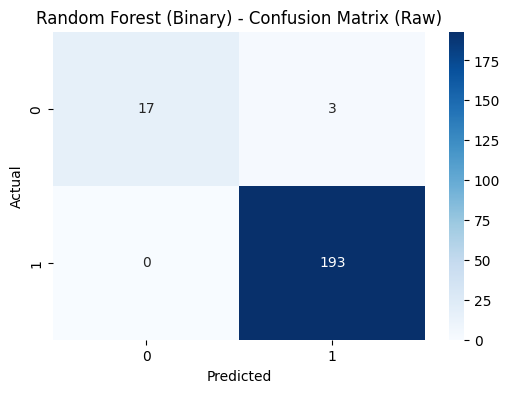

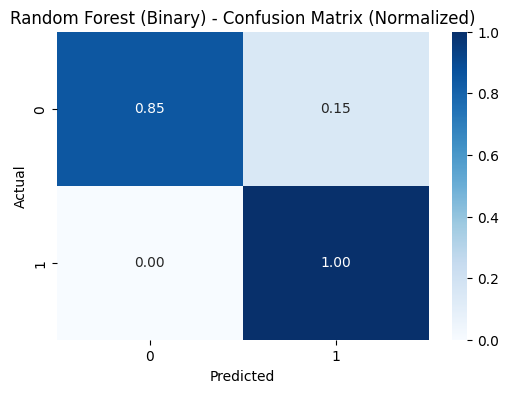

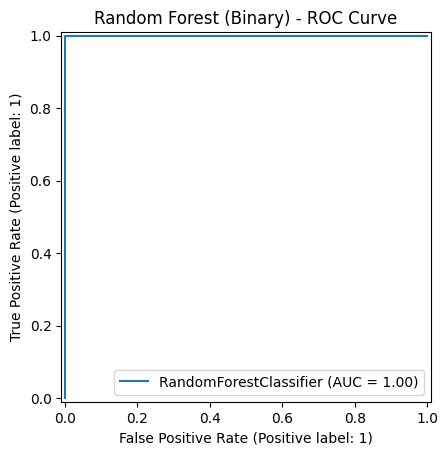


--- Multiclass Attack-Type classification ---
Accuracy: 0.9530516431924883

Confusion Matrix (raw):
 [[18  0  0  0  2  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 19  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  3  3]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9000    0.9474        20
           1     1.0000    1.0000    1.0000        18
           2     1.0000    1.0000    1.0000        19
           3     0.9565    1.0000    0.9778        22
           4     0.9048    0.9500    0.9268        20
           5     1.0000    1.0000    1.0000        19
           6     1.0000  

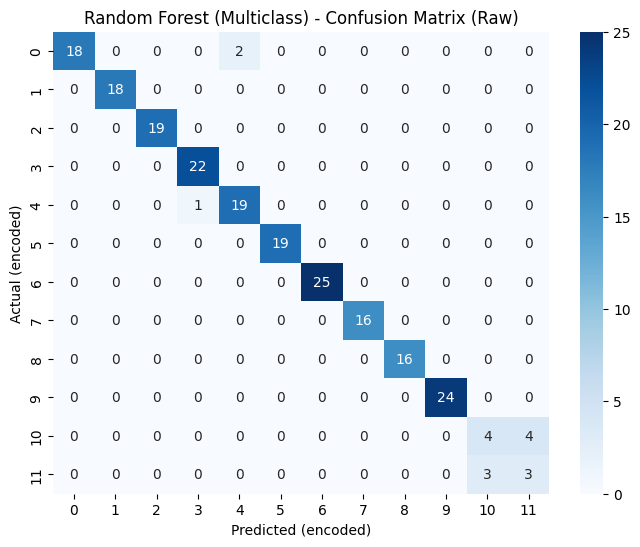


Multiclass detected — plotting One-vs-Rest ROC curves (robust)
Skipping class Infiltration — no positive samples in test set for this class.
Skipping class Web Attack � Sql Injection — no positive samples in test set for this class.


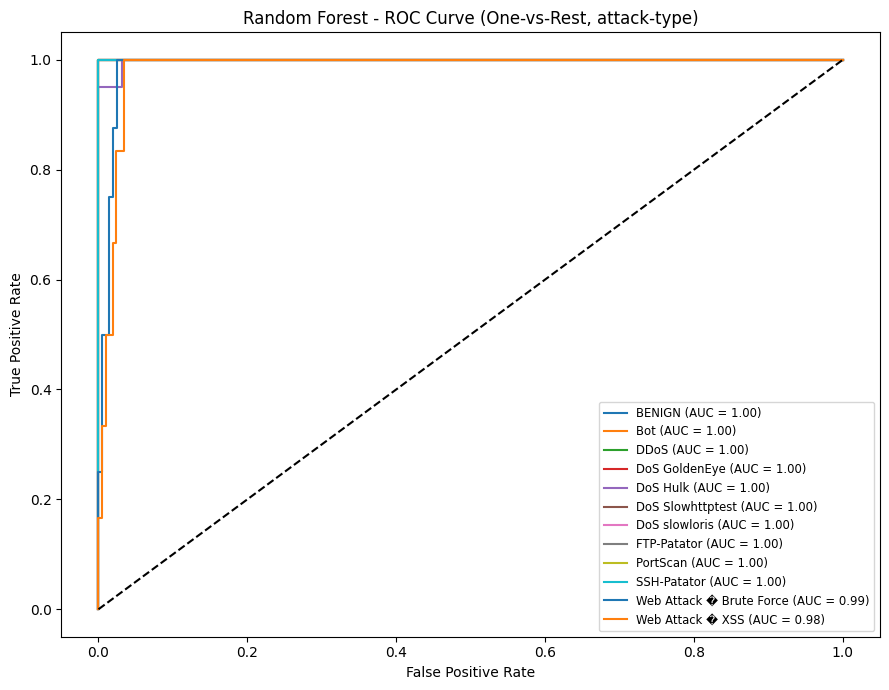

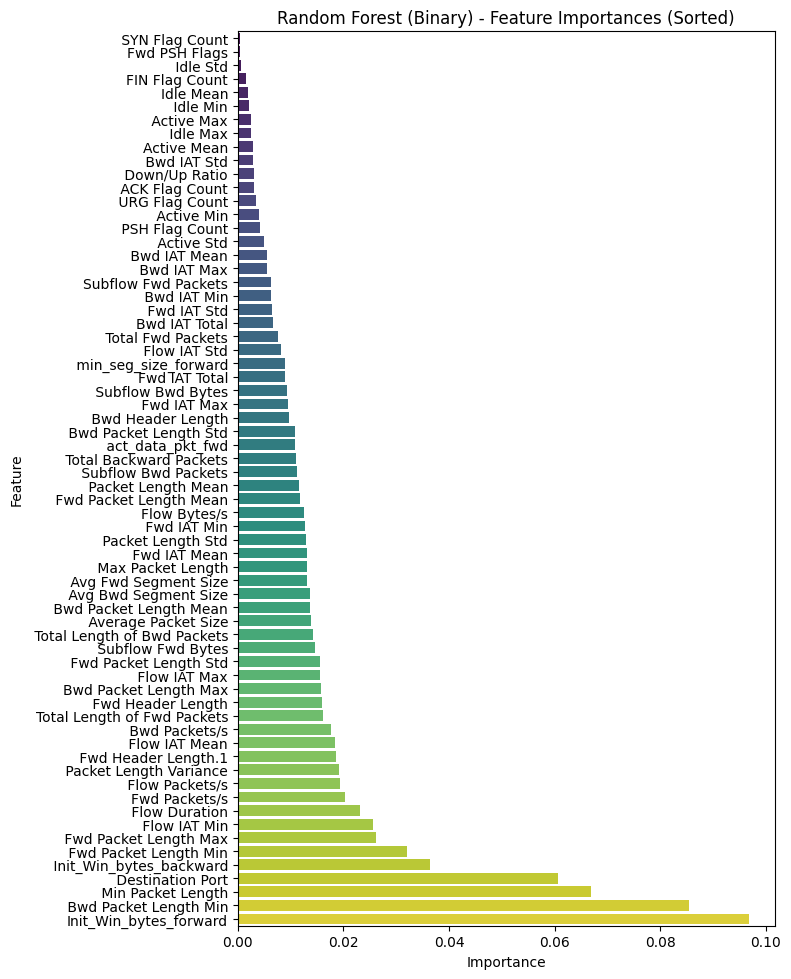

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    roc_curve,
    auc
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

print("\n======= RANDOM FOREST (BINARY + MULTICLASS) =======")

# ---------------------------
# 1) RANDOM FOREST - BINARY (BENIGN vs ATTACK)
# ---------------------------
rf_binary = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_binary.fit(X_train, y_binary_train)

# Predictions (binary)
pred_rf_bin = rf_binary.predict(X_test)

print("\n--- Binary classification (BENIGN=0 / ATTACK=1) ---")
print("Accuracy:", accuracy_score(y_binary_test, pred_rf_bin))
print("\nConfusion Matrix (raw):\n", confusion_matrix(y_binary_test, pred_rf_bin))
print("\nClassification Report:\n", classification_report(y_binary_test, pred_rf_bin, digits=4))

# Confusion matrix - raw
cm = confusion_matrix(y_binary_test, pred_rf_bin)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest (Binary) - Confusion Matrix (Raw)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix - normalized
cm_norm = confusion_matrix(y_binary_test, pred_rf_bin, normalize='true')
plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Random Forest (Binary) - Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (binary)
if len(np.unique(y_binary_test)) == 2:
    RocCurveDisplay.from_estimator(rf_binary, X_test, y_binary_test)
    plt.title("Random Forest (Binary) - ROC Curve")
    plt.show()

# ---------------------------
# 2) RANDOM FOREST - MULTICLASS (Attack type)
# ---------------------------
rf_multi = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_multi.fit(X_train, y_attack_train)

# Predictions (multiclass)
pred_rf_attack = rf_multi.predict(X_test)

print("\n--- Multiclass Attack-Type classification ---")
print("Accuracy:", accuracy_score(y_attack_test, pred_rf_attack))
print("\nConfusion Matrix (raw):\n", confusion_matrix(y_attack_test, pred_rf_attack))
print("\nClassification Report:\n", classification_report(y_attack_test, pred_rf_attack, digits=4))

# Confusion matrix - raw (multiclass)
cm = confusion_matrix(y_attack_test, pred_rf_attack)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest (Multiclass) - Confusion Matrix (Raw)")
plt.xlabel("Predicted (encoded)")
plt.ylabel("Actual (encoded)")
plt.show()

# ---------------------------
# Multiclass ROC (One-vs-Rest) — robust plotting
# ---------------------------
print("\nMulticlass detected — plotting One-vs-Rest ROC curves (robust)")

# Fit One-vs-Rest wrapper and get probability matrix
clf_ovr = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
clf_ovr.fit(X_train, y_attack_train)
y_score = clf_ovr.predict_proba(X_test)  # shape: (n_samples, n_classes_ovr)
ovr_classes = np.array(clf_ovr.classes_)  # class order used by the classifier

# Binarize y_test using the exact same class ordering
y_test_bin = label_binarize(y_attack_test, classes=ovr_classes)

# Defensive alignment (pad/truncate if shapes differ)
if y_test_bin.shape[1] < y_score.shape[1]:
    pad_cols = y_score.shape[1] - y_test_bin.shape[1]
    y_test_bin = np.hstack([y_test_bin, np.zeros((y_test_bin.shape[0], pad_cols), dtype=int)])
elif y_test_bin.shape[1] > y_score.shape[1]:
    y_test_bin = y_test_bin[:, :y_score.shape[1]]

# Try to map encoded classes to human-readable names if attack_encoder present
use_names = False
try:
    attack_encoder  # noqa: F821
    use_names = True
except NameError:
    use_names = False

def class_label(i):
    if use_names:
        try:
            return attack_encoder.inverse_transform([ovr_classes[i]])[0]
        except Exception:
            return str(ovr_classes[i])
    else:
        return str(ovr_classes[i])

plt.figure(figsize=(9, 7))
plotted_any = False
for i in range(y_score.shape[1]):
    # skip ROC if this class has no positive samples in y_test
    if np.sum(y_test_bin[:, i]) == 0:
        print(f"Skipping class {class_label(i)} — no positive samples in test set for this class.")
        continue
    try:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_label(i)} (AUC = {auc_val:.2f})")
        plotted_any = True
    except Exception as e:
        print(f"Could not compute ROC for class {class_label(i)}: {e}")
        continue

if plotted_any:
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Random Forest - ROC Curve (One-vs-Rest, attack-type)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='best', fontsize='small')
    plt.tight_layout()
    plt.show()
else:
    print("No per-class ROC curves were plotted (no usable positive samples in test set).")

# ---------------------------
# 3) FEATURE IMPORTANCE (from binary model)
# ---------------------------
importances = rf_binary.feature_importances_

# Use preserved feature_names (from preprocessing)
try:
    feature_names_used = feature_names
except NameError:
    # fallback: generate generic names
    feature_names_used = [f"Feature {i}" for i in range(X_train.shape[1])]

# Sort importance
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, max(6, len(sorted_idx)*0.15)))
sns.barplot(
    x=importances[sorted_idx],
    y=[feature_names_used[i] for i in sorted_idx],
    palette="viridis"
)
plt.title("Random Forest (Binary) - Feature Importances (Sorted)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


======= LOGISTIC REGRESSION (BINARY + MULTICLASS) =======

--- Binary classification (BENIGN=0 / ATTACK=1) ---
Accuracy: 0.971830985915493

Confusion Matrix (raw):
 [[ 14   6]
 [  0 193]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.7000    0.8235        20
           1     0.9698    1.0000    0.9847       193

    accuracy                         0.9718       213
   macro avg     0.9849    0.8500    0.9041       213
weighted avg     0.9727    0.9718    0.9696       213



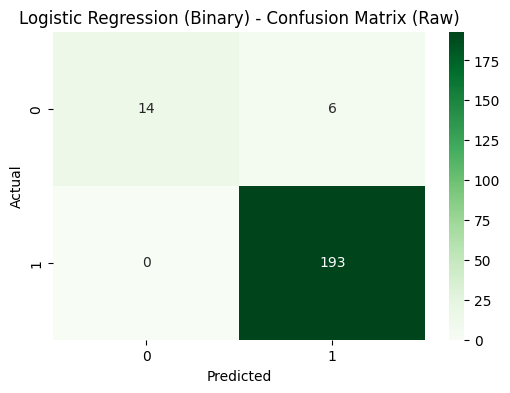

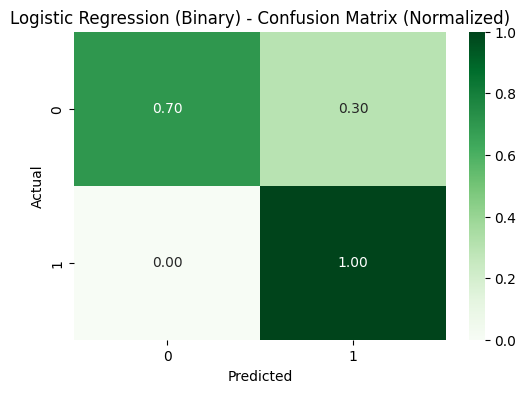

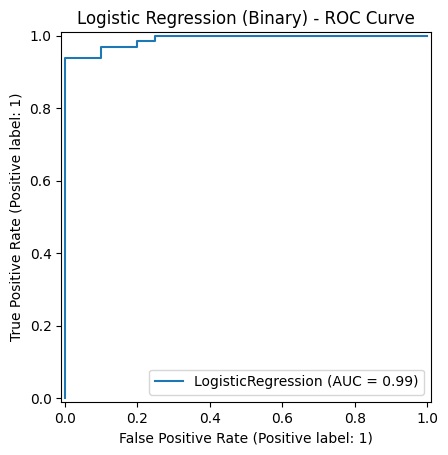


--- Multiclass Attack-Type classification ---
Accuracy: 0.92018779342723

Confusion Matrix (raw):
 [[17  0  1  0  1  0  0  0  1  0  0  0]
 [ 0 12  0  0  0  0  0  0  6  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  1  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.8500    0.9189        20
           1     1.0000    0.6667    0.8000        18
           2     0.9500    1.0000    0.9744        19
           3     1.0000    0.9545    0.9767        22
           4     0.9500    0.9500    0.9500        20
           5     0.9500    1.0000    0.9744        19
           6     1.0000    

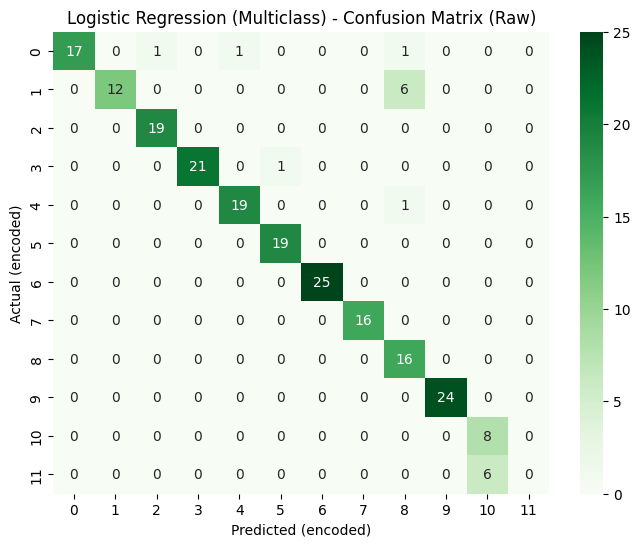


Multiclass detected — plotting One-vs-Rest ROC curves (robust)
Skipping class Infiltration — no positive samples in test set.
Skipping class Web Attack � Sql Injection — no positive samples in test set.


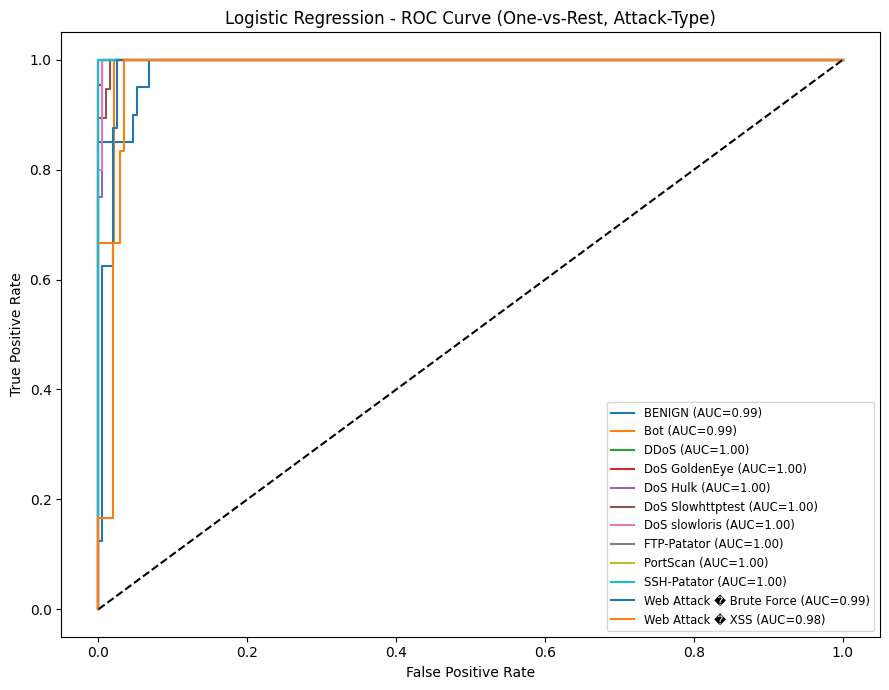


--- Feature Importance (Binary Logistic Regression) ---


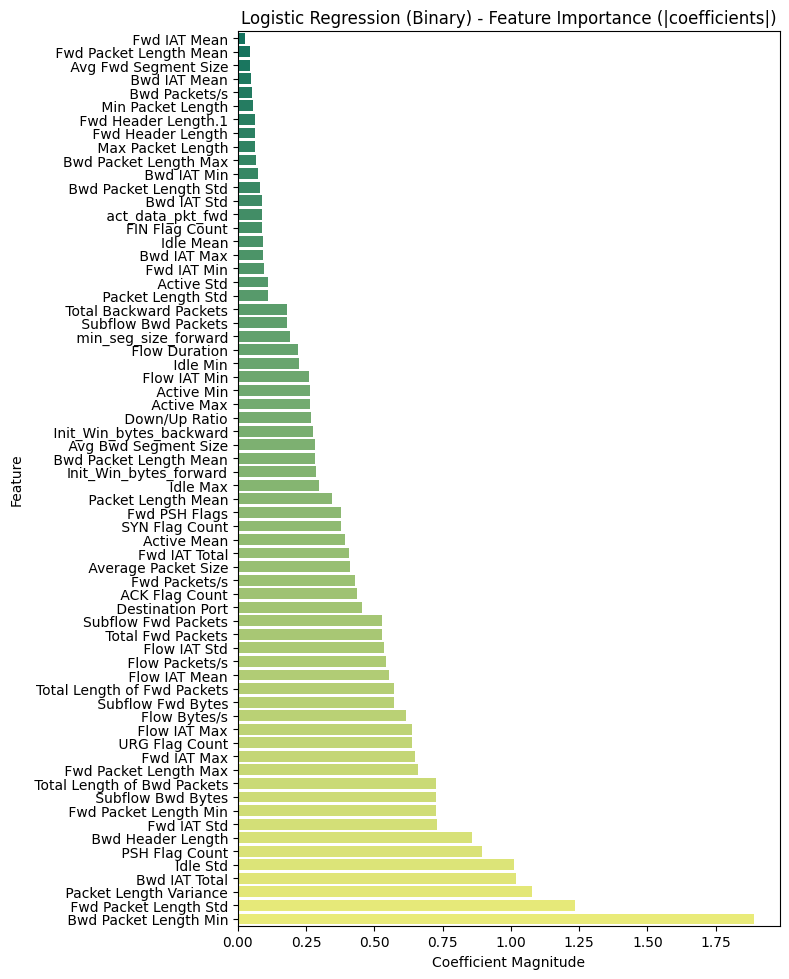


--- Feature Importance (Multiclass Logistic Regression) ---


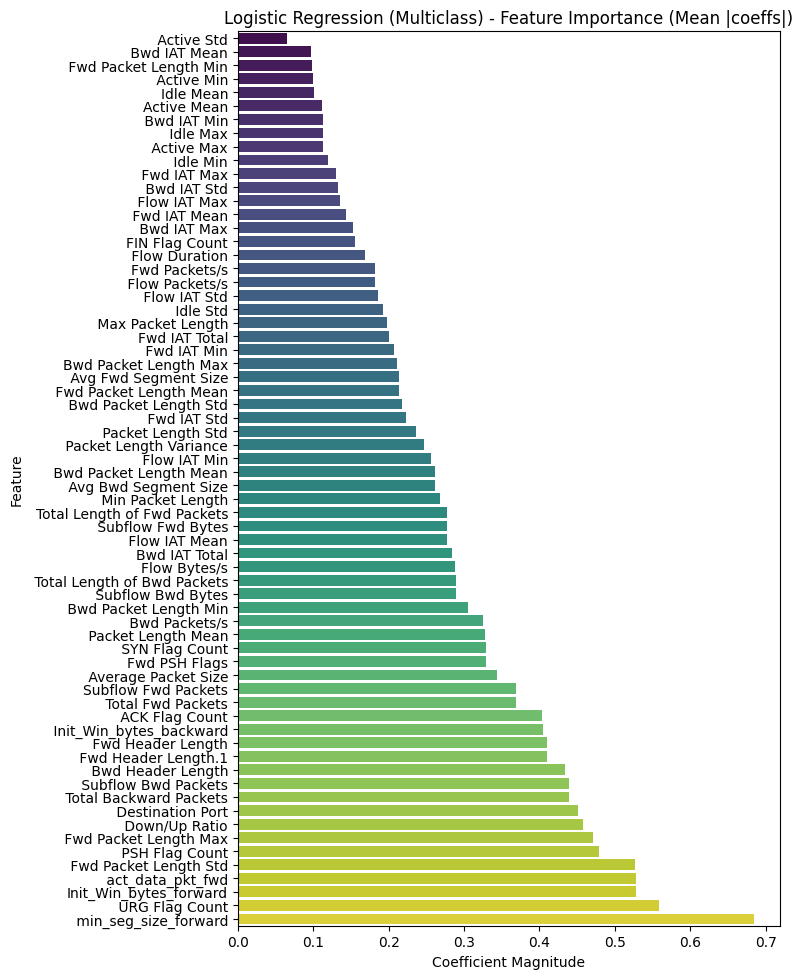

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    roc_curve,
    auc
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

print("\n======= LOGISTIC REGRESSION (BINARY + MULTICLASS) =======")

# ---------------------------
# 1) LOGISTIC REGRESSION - BINARY (BENIGN vs ATTACK)
# ---------------------------
lr_binary = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
lr_binary.fit(X_train, y_binary_train)

pred_lr_bin = lr_binary.predict(X_test)

print("\n--- Binary classification (BENIGN=0 / ATTACK=1) ---")
print("Accuracy:", accuracy_score(y_binary_test, pred_lr_bin))
print("\nConfusion Matrix (raw):\n", confusion_matrix(y_binary_test, pred_lr_bin))
print("\nClassification Report:\n", classification_report(y_binary_test, pred_lr_bin, digits=4))

# Confusion matrix (binary)
cm = confusion_matrix(y_binary_test, pred_lr_bin)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression (Binary) - Confusion Matrix (Raw)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix normalized
cm_norm = confusion_matrix(y_binary_test, pred_lr_bin, normalize='true')
plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens')
plt.title("Logistic Regression (Binary) - Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve (binary)
if len(np.unique(y_binary_test)) == 2:
    RocCurveDisplay.from_estimator(lr_binary, X_test, y_binary_test)
    plt.title("Logistic Regression (Binary) - ROC Curve")
    plt.show()

# ---------------------------
# 2) LOGISTIC REGRESSION - MULTICLASS (Attack type)
# ---------------------------
lr_multi = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto', random_state=42)
lr_multi.fit(X_train, y_attack_train)

pred_lr_attack = lr_multi.predict(X_test)

print("\n--- Multiclass Attack-Type classification ---")
print("Accuracy:", accuracy_score(y_attack_test, pred_lr_attack))
print("\nConfusion Matrix (raw):\n", confusion_matrix(y_attack_test, pred_lr_attack))
print("\nClassification Report:\n", classification_report(y_attack_test, pred_lr_attack, digits=4))

# Confusion matrix - raw (multiclass)
cm = confusion_matrix(y_attack_test, pred_lr_attack)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression (Multiclass) - Confusion Matrix (Raw)")
plt.xlabel("Predicted (encoded)")
plt.ylabel("Actual (encoded)")
plt.show()

# ---------------------------
# Multiclass ROC (Robust OVR)
# ---------------------------
print("\nMulticlass detected — plotting One-vs-Rest ROC curves (robust)")

clf_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='lbfgs'))
clf_ovr.fit(X_train, y_attack_train)
y_score = clf_ovr.predict_proba(X_test)
ovr_classes = np.array(clf_ovr.classes_)

y_test_bin = label_binarize(y_attack_test, classes=ovr_classes)

# Align shapes if needed
if y_test_bin.shape[1] < y_score.shape[1]:
    pad = y_score.shape[1] - y_test_bin.shape[1]
    y_test_bin = np.hstack([y_test_bin, np.zeros((y_test_bin.shape[0], pad), dtype=int)])
elif y_test_bin.shape[1] > y_score.shape[1]:
    y_test_bin = y_test_bin[:, :y_score.shape[1]]

# Text names for classes
use_names = False
try:
    attack_encoder
    use_names = True
except:
    pass

def class_label(i):
    if use_names:
        try:
            return attack_encoder.inverse_transform([ovr_classes[i]])[0]
        except:
            return str(ovr_classes[i])
    else:
        return str(ovr_classes[i])

plt.figure(figsize=(9, 7))
plotted_any = False
for i in range(y_score.shape[1]):
    if np.sum(y_test_bin[:, i]) == 0:
        print(f"Skipping class {class_label(i)} — no positive samples in test set.")
        continue

    try:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_label(i)} (AUC={auc_val:.2f})")
        plotted_any = True
    except:
        continue

if plotted_any:
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Logistic Regression - ROC Curve (One-vs-Rest, Attack-Type)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.show()

# ---------------------------
# 3) FEATURE IMPORTANCE (Binary LR)
# ---------------------------
print("\n--- Feature Importance (Binary Logistic Regression) ---")

coef_binary = lr_binary.coef_[0]   # shape: (n_features,)
importance = np.abs(coef_binary)

sorted_idx = np.argsort(importance)

plt.figure(figsize=(8, max(6, len(sorted_idx)*0.15)))
sns.barplot(
    x=importance[sorted_idx],
    y=[feature_names[i] for i in sorted_idx],
    palette="summer"
)
plt.title("Logistic Regression (Binary) - Feature Importance (|coefficients|)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ---------------------------
# 4) FEATURE IMPORTANCE (Multiclass LR)
# ---------------------------
print("\n--- Feature Importance (Multiclass Logistic Regression) ---")

coef_multi = np.mean(np.abs(lr_multi.coef_), axis=0)

sorted_idx = np.argsort(coef_multi)

plt.figure(figsize=(8, max(6, len(sorted_idx)*0.15)))
sns.barplot(
    x=coef_multi[sorted_idx],
    y=[feature_names[i] for i in sorted_idx],
    palette="viridis"
)
plt.title("Logistic Regression (Multiclass) - Feature Importance (Mean |coeffs|)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


======= SVM (RBF) — BINARY + MULTICLASS =======

--- Binary SVM (BENIGN=0 / ATTACK=1) ---
Accuracy: 0.9671361502347418

Confusion Matrix:
 [[ 13   7]
 [  0 193]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.6500    0.7879        20
           1     0.9650    1.0000    0.9822       193

    accuracy                         0.9671       213
   macro avg     0.9825    0.8250    0.8850       213
weighted avg     0.9683    0.9671    0.9639       213



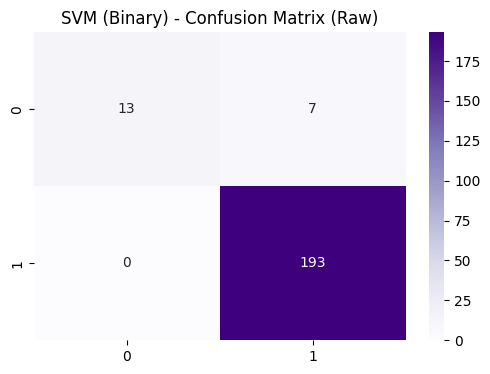

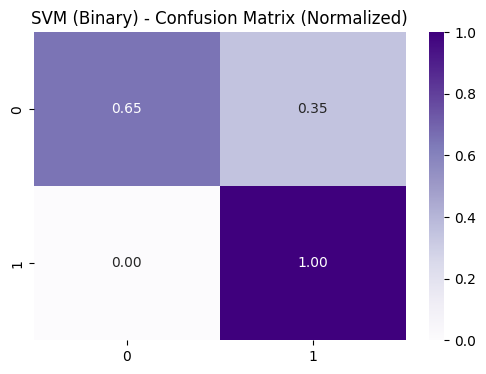

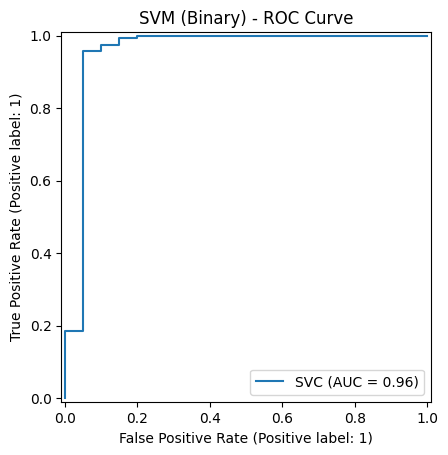


--- Multiclass SVM (Attack Type) ---
Accuracy: 0.8497652582159625

Confusion Matrix:
 [[15  1  1  1  1  0  0  0  1  0  0  0]
 [ 0 12  0  0  0  0  0  0  6  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 20  0  1  0  0  0  0  0  0]
 [ 4  0  0  1 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  1  0  0  1  0  0]
 [ 0  0  0  0  0  1 21  3  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0]
 [ 2  0  0  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0]]

Classification Report:
               precision    recall  f1-score   support

           0     0.6818    0.7500    0.7143        20
           1     0.9231    0.6667    0.7742        18
           2     0.9500    1.0000    0.9744        19
           3     0.9091    0.9091    0.9091        22
           4     0.9375    0.7500    0.8333        20
           5     0.8947    0.8947    0.8947        19
           6     0.9545    0.8400    0.8

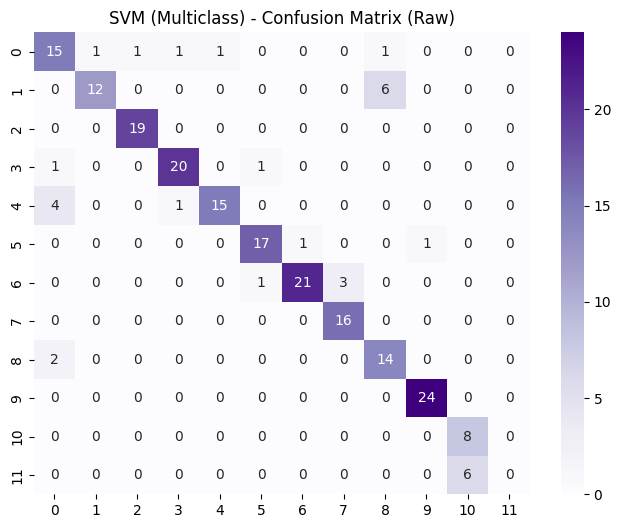


Preparing ROC curves (robust OVR)...
Skipping class Infiltration — no positive samples.
Skipping class Web Attack � Sql Injection — no positive samples.


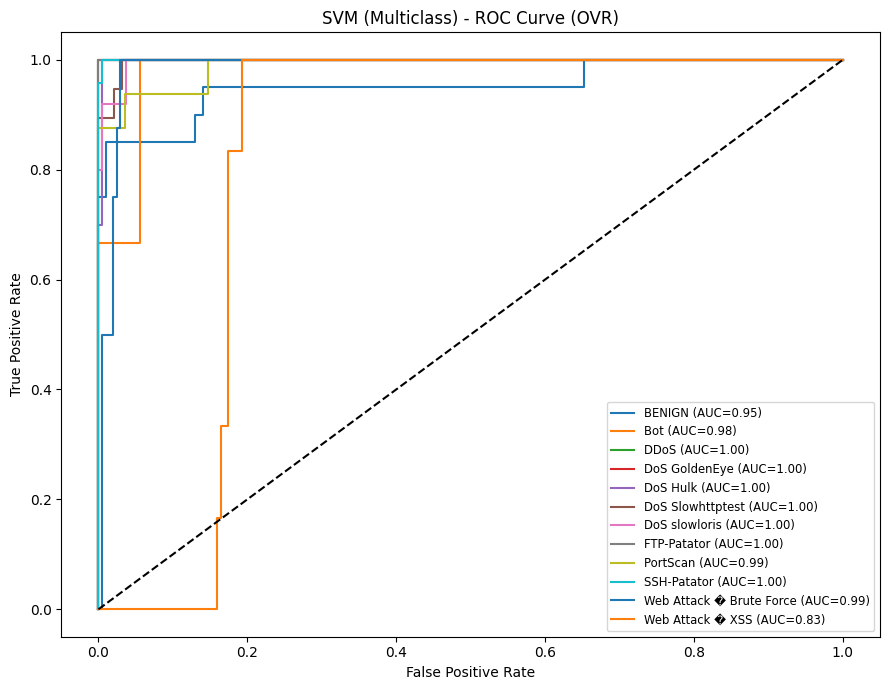


--- Computing Feature Importance (Permutation) ---


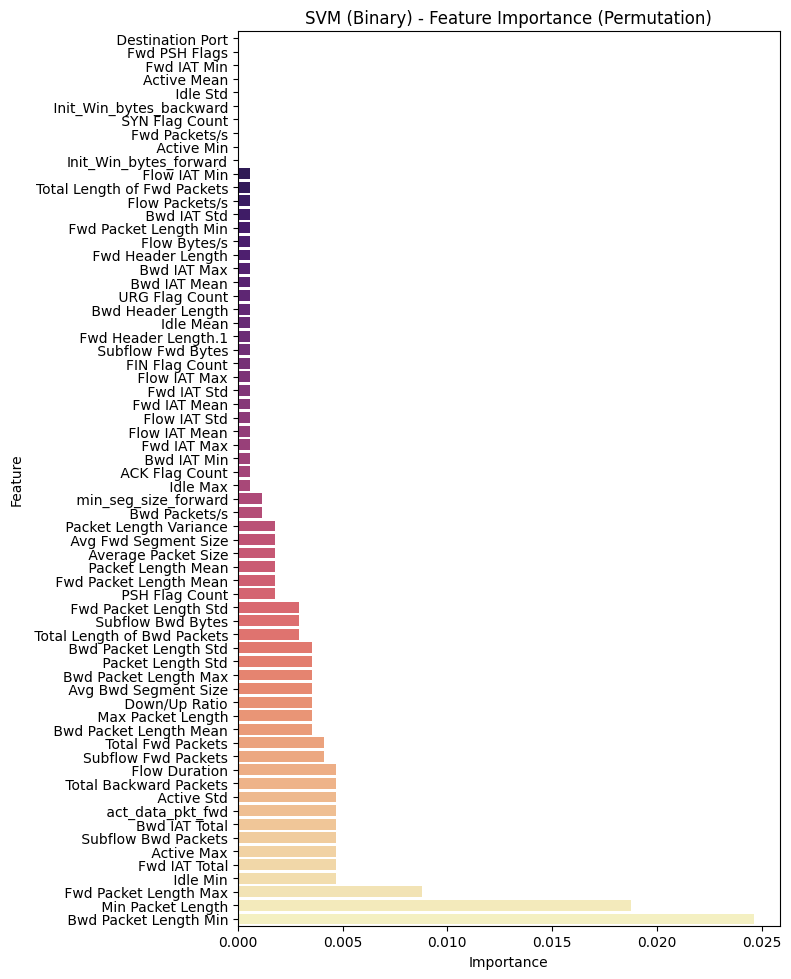

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    roc_curve,
    auc
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance


print("\n======= SVM (RBF) — BINARY + MULTICLASS =======")


# ======================================================
# 1) SVM (BINARY) — BENIGN vs ATTACK
# ======================================================
svm_binary = SVC(kernel='rbf', probability=True, random_state=42)
svm_binary.fit(X_train, y_binary_train)

pred_svm_bin = svm_binary.predict(X_test)

print("\n--- Binary SVM (BENIGN=0 / ATTACK=1) ---")
print("Accuracy:", accuracy_score(y_binary_test, pred_svm_bin))
print("\nConfusion Matrix:\n", confusion_matrix(y_binary_test, pred_svm_bin))
print("\nClassification Report:\n", classification_report(y_binary_test, pred_svm_bin, digits=4))

cm = confusion_matrix(y_binary_test, pred_svm_bin)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("SVM (Binary) - Confusion Matrix (Raw)")
plt.show()

cm_norm = confusion_matrix(y_binary_test, pred_svm_bin, normalize='true')
plt.figure(figsize=(6,4))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Purples')
plt.title("SVM (Binary) - Confusion Matrix (Normalized)")
plt.show()

# ROC curve (binary)
RocCurveDisplay.from_estimator(svm_binary, X_test, y_binary_test)
plt.title("SVM (Binary) - ROC Curve")
plt.show()


# ======================================================
# 2) SVM (MULTICLASS) — ATTACK TYPE
# ======================================================
svm_multi = SVC(kernel='rbf', probability=True, random_state=42)
svm_multi.fit(X_train, y_attack_train)

pred_svm_attack = svm_multi.predict(X_test)

print("\n--- Multiclass SVM (Attack Type) ---")
print("Accuracy:", accuracy_score(y_attack_test, pred_svm_attack))
print("\nConfusion Matrix:\n", confusion_matrix(y_attack_test, pred_svm_attack))
print("\nClassification Report:\n", classification_report(y_attack_test, pred_svm_attack, digits=4))

cm = confusion_matrix(y_attack_test, pred_svm_attack)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("SVM (Multiclass) - Confusion Matrix (Raw)")
plt.show()


# ======================================================
# 3) Multiclass ROC — Robust One-vs-Rest
# ======================================================
print("\nPreparing ROC curves (robust OVR)...")

clf_ovr = OneVsRestClassifier(SVC(kernel='rbf', probability=True))
clf_ovr.fit(X_train, y_attack_train)
y_score = clf_ovr.predict_proba(X_test)
ovr_classes = clf_ovr.classes_

y_test_bin = label_binarize(y_attack_test, classes=ovr_classes)

# Fix mismatch shapes
if y_test_bin.shape[1] < y_score.shape[1]:
    pad = y_score.shape[1] - y_test_bin.shape[1]
    y_test_bin = np.hstack([y_test_bin, np.zeros((y_test_bin.shape[0], pad))])
elif y_test_bin.shape[1] > y_score.shape[1]:
    y_test_bin = y_test_bin[:, :y_score.shape[1]]

# human-readable class labels
use_names = False
try:
    attack_encoder
    use_names = True
except:
    pass

def class_label(i):
    if use_names:
        try:
            return attack_encoder.inverse_transform([ovr_classes[i]])[0]
        except:
            return str(ovr_classes[i])
    else:
        return str(ovr_classes[i])


plt.figure(figsize=(9, 7))
plotted_any = False

for i in range(y_score.shape[1]):
    if np.sum(y_test_bin[:, i]) == 0:
        print(f"Skipping class {class_label(i)} — no positive samples.")
        continue
    try:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_label(i)} (AUC={auc_val:.2f})")
        plotted_any = True
    except:
        continue

if plotted_any:
    plt.plot([0,1],[0,1],'k--')
    plt.title("SVM (Multiclass) - ROC Curve (OVR)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.show()
else:
    print("No ROC curves could be plotted.")


# ======================================================
# 4) FEATURE IMPORTANCE — Permutation Importance
# ======================================================
print("\n--- Computing Feature Importance (Permutation) ---")

wrapper = svm_binary  # use binary model for importance

result = permutation_importance(
    wrapper,
    X_test,
    y_binary_test,
    n_repeats=8,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, max(6, len(sorted_idx)*0.15)))
sns.barplot(
    x=importances[sorted_idx],
    y=[feature_names[i] for i in sorted_idx],
    palette="magma"
)
plt.title("SVM (Binary) - Feature Importance (Permutation)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


======= ARTIFICIAL NEURAL NETWORK (ANN) =======

Training ANN (Binary)...
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4340 - loss: 0.8364
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9033 - loss: 0.4198
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9340 - loss: 0.2938
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.2313
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.1970
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9399 - loss: 0.1752 
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9410 - loss: 0.1599
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9446 - loss: 0.1486 
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9446 - loss: 0.1400 
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9493 - loss: 0.1330 

Binary ANN Accuracy: 0.9530516266822815
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


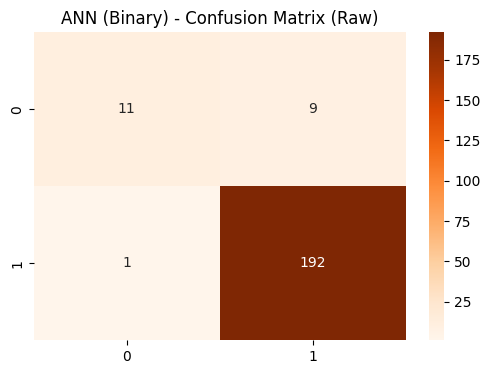

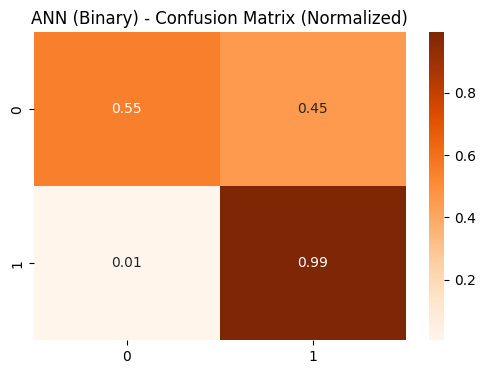


Binary Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.55      0.69        20
           1       0.96      0.99      0.97       193

    accuracy                           0.95       213
   macro avg       0.94      0.77      0.83       213
weighted avg       0.95      0.95      0.95       213



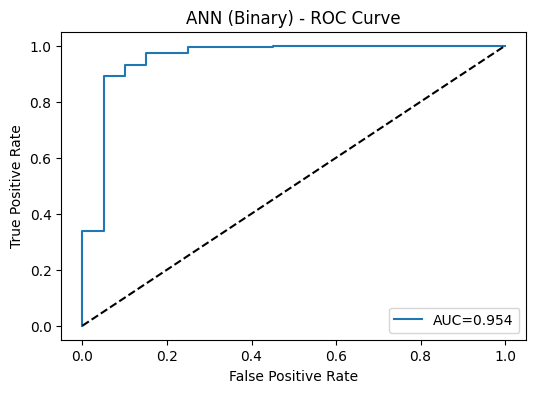


Training ANN (Multiclass)...
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1191 - loss: 2.6060
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3467 - loss: 2.1108
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5519 - loss: 1.7655 
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6616 - loss: 1.4714
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7217 - loss: 1.2310
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7465 - loss: 1.0426
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7972 - loss: 0.8935
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8031 - loss: 0.7728 
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8278 - loss: 0.6770
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8526 - loss: 0.6005

Multiclass ANN Accuracy: 0.8544601202011108
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


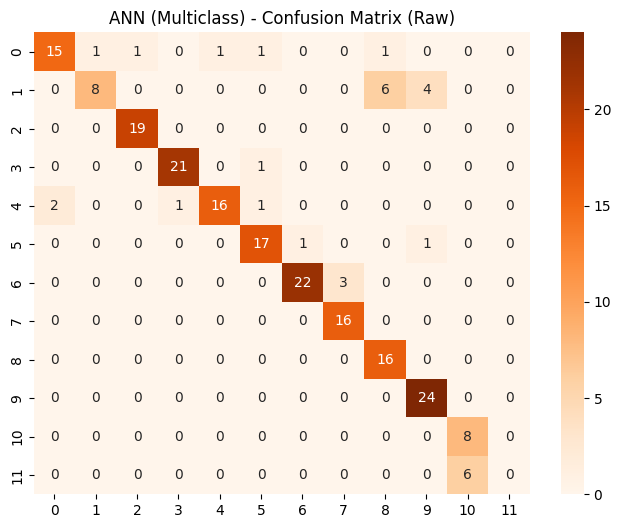


Multiclass Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81        20
           1       0.89      0.44      0.59        18
           2       0.95      1.00      0.97        19
           3       0.95      0.95      0.95        22
           4       0.94      0.80      0.86        20
           5       0.85      0.89      0.87        19
           6       0.96      0.88      0.92        25
           7       0.84      1.00      0.91        16
           9       0.70      1.00      0.82        16
          10       0.83      1.00      0.91        24
          11       0.57      1.00      0.73         8
          13       0.00      0.00      0.00         6

    accuracy                           0.85       213
   macro avg       0.78      0.81      0.78       213
weighted avg       0.85      0.85      0.84       213

Skipping class Infiltration — no positive samples in test set.
Skipping class Web Attack � Sql In

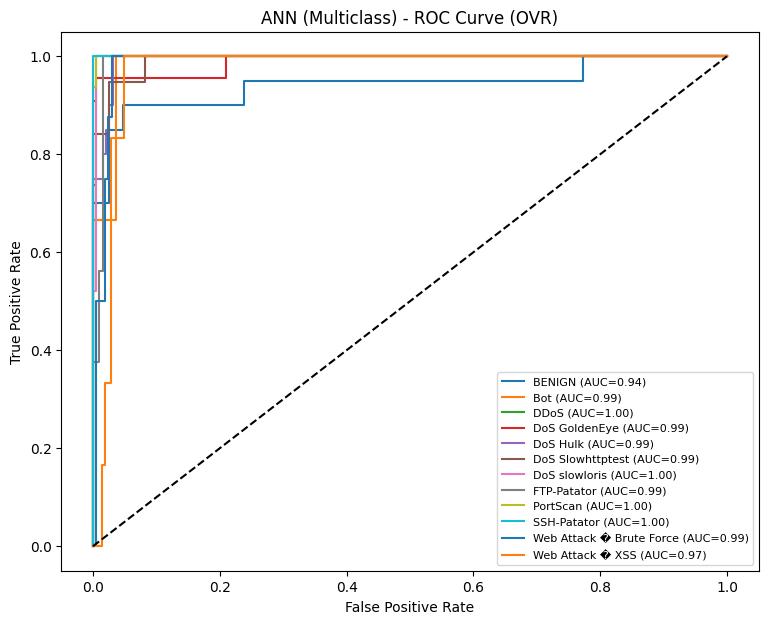


Computing ANN feature importance (Permutation)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


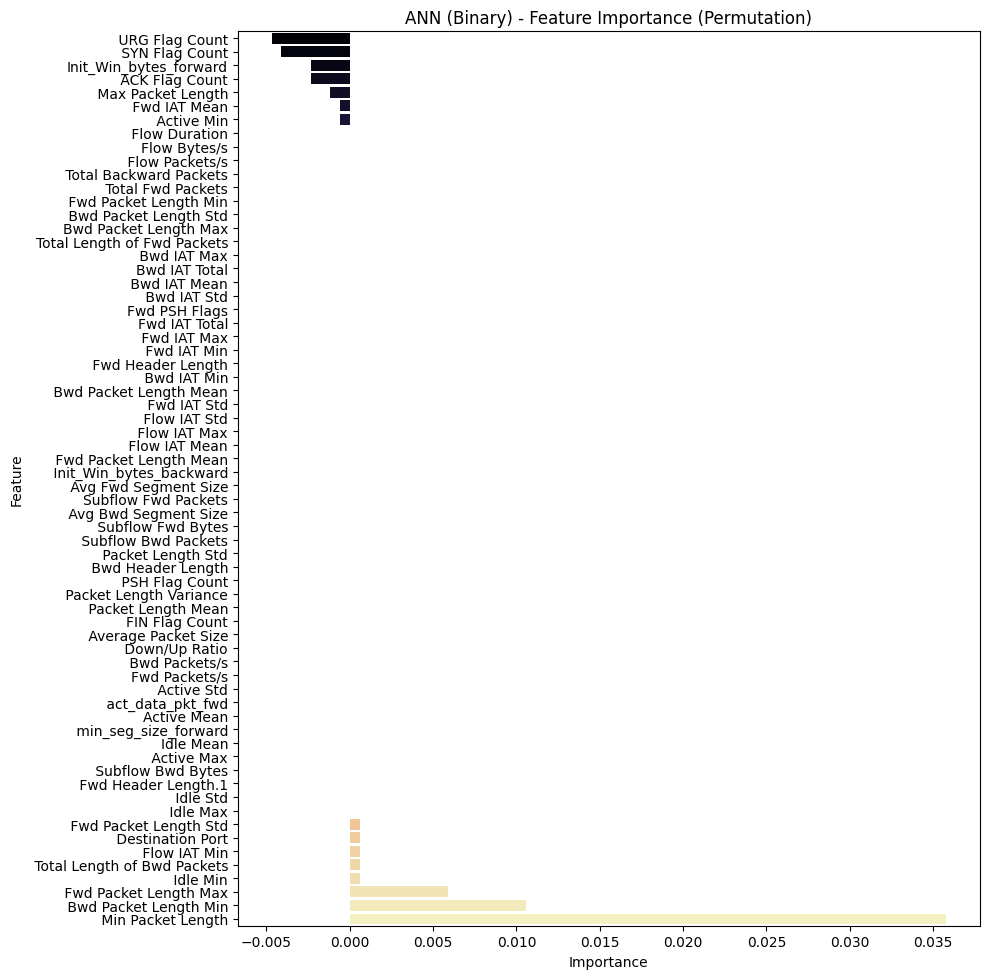

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

print("\n======= ARTIFICIAL NEURAL NETWORK (ANN) =======")

# ======================================================
# 1) ANN — BINARY MODEL (BENIGN vs ATTACK)
# ======================================================
binary_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

binary_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

print("\nTraining ANN (Binary)...")
binary_model.fit(X_train, y_binary_train, epochs=10, batch_size=64, verbose=1)

# Evaluate
loss, acc = binary_model.evaluate(X_test, y_binary_test, verbose=0)
print("\nBinary ANN Accuracy:", acc)

# Predictions
pred_prob_bin = binary_model.predict(X_test).flatten()
pred_bin = (pred_prob_bin > 0.5).astype(int)

# --- Confusion Matrix (Binary)
cm = confusion_matrix(y_binary_test, pred_bin)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("ANN (Binary) - Confusion Matrix (Raw)")
plt.show()

cm_norm = confusion_matrix(y_binary_test, pred_bin, normalize='true')
plt.figure(figsize=(6,4))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Oranges')
plt.title("ANN (Binary) - Confusion Matrix (Normalized)")
plt.show()

print("\nBinary Classification Report:\n",
      classification_report(y_binary_test, pred_bin))

# ROC curve (binary)
fpr, tpr, _ = roc_curve(y_binary_test, pred_prob_bin)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ANN (Binary) - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ======================================================
# 2) ANN — MULTICLASS MODEL (Attack Type Classification)
# ======================================================
num_classes = len(np.unique(y_attack_train))

multiclass_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

multiclass_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

print("\nTraining ANN (Multiclass)...")
multiclass_model.fit(X_train, y_attack_train, epochs=10, batch_size=64, verbose=1)

# Evaluate
loss2, acc2 = multiclass_model.evaluate(X_test, y_attack_test, verbose=0)
print("\nMulticlass ANN Accuracy:", acc2)

# Predictions
prob_multi = multiclass_model.predict(X_test)
pred_multi = np.argmax(prob_multi, axis=1)

# --- Confusion Matrix (Multiclass)
cm = confusion_matrix(y_attack_test, pred_multi)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("ANN (Multiclass) - Confusion Matrix (Raw)")
plt.show()

print("\nMulticlass Classification Report:\n",
      classification_report(y_attack_test, pred_multi))

# ======================================================
# 3) Multiclass ROC (Robust handling for rare/missing classes)
# ======================================================
# Build class index set matching the trained output layer: 0..num_classes-1
trained_classes = np.arange(num_classes)

# Binarize y_test using the full trained_classes to ensure column alignment
y_test_bin = label_binarize(y_attack_test, classes=trained_classes)

# Defensive alignment: ensure y_test_bin and prob_multi have same number of columns
if y_test_bin.shape[1] < prob_multi.shape[1]:
    pad = prob_multi.shape[1] - y_test_bin.shape[1]
    y_test_bin = np.hstack([y_test_bin, np.zeros((y_test_bin.shape[0], pad), dtype=int)])
elif y_test_bin.shape[1] > prob_multi.shape[1]:
    y_test_bin = y_test_bin[:, :prob_multi.shape[1]]

# Prepare human-readable class labels if attack_encoder exists
use_names = False
try:
    attack_encoder  # noqa: F821
    use_names = True
except NameError:
    use_names = False

def class_label(i):
    if use_names:
        try:
            return attack_encoder.inverse_transform([i])[0]
        except Exception:
            return str(i)
    else:
        return str(i)

plt.figure(figsize=(9, 7))
plotted_any = False

# iterate over number of output columns (safe)
for i in range(prob_multi.shape[1]):
    # If no positive samples for this class in test, skip plotting
    if np.sum(y_test_bin[:, i]) == 0:
        print(f"Skipping class {class_label(i)} — no positive samples in test set.")
        continue
    try:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], prob_multi[:, i])
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_label(i)} (AUC={auc_val:.2f})")
        plotted_any = True
    except Exception as e:
        print(f"Could not compute ROC for class {class_label(i)}: {e}")
        continue

if plotted_any:
    plt.plot([0,1],[0,1],'k--')
    plt.title("ANN (Multiclass) - ROC Curve (OVR)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize=8)
    plt.show()
else:
    print("No valid class ROC curves to plot (likely due to very-rare classes).")

# ======================================================
# 4) PERMUTATION FEATURE IMPORTANCE (Binary ANN)
# ======================================================
class KerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, binary=True):
        self.model = model
        self.binary = binary

    def fit(self, X, y):
        return self

    def predict(self, X):
        pred = self.model.predict(X)
        if self.binary:
            return (pred.flatten() > 0.5).astype(int)
        return np.argmax(pred, axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)

print("\nComputing ANN feature importance (Permutation)...")
wrapper_bin = KerasWrapper(binary_model, binary=True)

result = permutation_importance(
    wrapper_bin,
    X_test,
    y_binary_test,
    n_repeats=8,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, max(6, len(sorted_idx)*0.15)))
sns.barplot(
    x=importances[sorted_idx],
    y=[feature_names[i] for i in sorted_idx],
    palette="magma"
)
plt.title("ANN (Binary) - Feature Importance (Permutation)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [82]:
# === DEFAULT FEATURE BASE (DATASET MEAN VALUES) ===
default_vector = X_df.mean().values
feature_names = X_df.columns.tolist()

In [83]:
def prepare_input(user_input):
    """
    Prepares a single IDS input sample.
    - Accepts JSON (dict) or numeric list
    - Any missing features auto-filled using dataset mean
    """
    vec = default_vector.copy()

    # ----- JSON INPUT -----
    if isinstance(user_input, dict):
        for key, val in user_input.items():
            if key in feature_names:
                i = feature_names.index(key)
                vec[i] = float(val)

    # ----- LIST INPUT -----
    elif isinstance(user_input, list):
        for i, val in enumerate(user_input):
            if i < len(vec):
                vec[i] = float(val)

    else:
        raise ValueError("Input must be JSON dict or numeric list.")

    return np.array(vec).reshape(1, -1)

In [91]:
def run_live_demo(user_input, ensemble_mode="majority", conservative_prob=0.9):
    """
    Live demo that shows:
      - per-model binary predictions (with probs)
      - final ensemble binary decision (BENIGN / ATTACK)
      - if ATTACK -> show only the attack FAMILY (DoS, Web Attack, Brute Force, ...)
        and family-level probabilities (sum of subtype probs)
    """
    # Family mapping (subtype -> family)
    attack_family_map = {
        "BENIGN": "BENIGN",
        "DoS Hulk": "DoS",
        "DoS GoldenEye": "DoS",
        "DoS slowloris": "DoS",
        "DoS Slowhttptest": "DoS",
        "DDoS": "DDoS",
        "FTP-Patator": "Brute Force",
        "SSH-Patator": "Brute Force",
        "Web Attack – Brute Force": "Web Attack",
        "Web Attack – XSS": "Web Attack",
        "Web Attack – SQL Injection": "Web Attack",
        "PortScan": "PortScan",
        "Bot": "Botnet",
        "Infiltration": "Infiltration"
    }

    print("="*60)
    print("                LIVE IDS DEMO (4-MODEL ENSEMBLE)")
    print("="*60)

    # ---------------------------
    # 1) Prepare + scale input
    # ---------------------------
    sample = prepare_input(user_input)
    sample_scaled = scaler.transform(sample)

    # ---------------------------
    # 2) BINARY PREDICTIONS (0=benign, 1=attack)
    # ---------------------------
    results_binary = {}

    # Random Forest (binary)
    prob_rf = float(rf_binary.predict_proba(sample_scaled)[0][1])
    pred_rf = int(prob_rf > 0.5)
    results_binary["RandomForest"] = (pred_rf, prob_rf)

    # Logistic Regression (binary)
    prob_lr = float(lr_binary.predict_proba(sample_scaled)[0][1])
    pred_lr = int(prob_lr > 0.5)
    results_binary["LogisticRegression"] = (pred_lr, prob_lr)

    # SVM (binary)
    prob_svm = float(svm_binary.predict_proba(sample_scaled)[0][1])
    pred_svm = int(prob_svm > 0.5)
    results_binary["SVM (RBF)"] = (pred_svm, prob_svm)

    # ANN (binary)
    ann_prob = float(binary_model.predict(sample_scaled).flatten()[0])
    pred_ann = int(ann_prob > 0.5)
    results_binary["ANN"] = (pred_ann, ann_prob)

    # ---------------------------
    # 3) MULTICLASS PREDICTION (attack type) - raw subtype probs
    # ---------------------------
    prob_attack = multiclass_model.predict(sample_scaled)[0]   # vector length = num_subtypes
    pred_attack_idx = int(np.argmax(prob_attack))

    # Try to decode subtype name (if encoder exists)
    try:
        subtype_names = list(attack_encoder.inverse_transform(np.arange(len(prob_attack))))
        pred_subtype_name = subtype_names[pred_attack_idx]
    except Exception:
        # fallback: use index string; we will map to generic ATTACK category
        subtype_names = [str(i) for i in range(len(prob_attack))]
        pred_subtype_name = subtype_names[pred_attack_idx]

    # ---------------------------
    # 4) MAP SUBTYPES -> FAMILY and compute family-level probs
    # ---------------------------
    family_probs = {}
    for i, subname in enumerate(subtype_names):
        family = attack_family_map.get(subname, "ATTACK")
        family_probs[family] = family_probs.get(family, 0.0) + float(prob_attack[i])

    # Choose predicted family (highest family prob)
    pred_family = max(family_probs.items(), key=lambda x: x[1])[0]
    pred_family_prob = family_probs[pred_family]

    # ---------------------------
    # 5) ENSEMBLE FINAL DECISION
    # ---------------------------
    votes = [pred_rf, pred_lr, pred_svm, pred_ann]

    if ensemble_mode == "conservative":
        # any model very confident -> attack
        if any(results_binary[m][1] >= conservative_prob for m in results_binary):
            final_pred = 1
            consensus = 'conservative_any_confident'
        else:
            final_pred = 1 if sum(votes) >= 2 else 0
            consensus = 'majority_fallback'
    else:
        final_pred = 1 if sum(votes) >= 2 else 0
        consensus = 'majority'

    final_label = "ATTACK ⚠️" if final_pred == 1 else "BENIGN 👍"
    decision_text = {0: "BENIGN 👍", 1: "ATTACK ⚠️"}

    # ---------------------------
    # 6) PRINT RESULTS (family-level for attacks)
    # ---------------------------
    print("\n--------------- MODEL OUTPUTS (BINARY) ---------------")
    for name, (pred, prob) in results_binary.items():
        print(f"{name:22s}: {pred} → {decision_text[pred]}   (P1={prob:.4f})")

    print("\n--------------- ATTACK CATEGORY (FAMILY) ---------------")
    if pred_family == "BENIGN":
        # If family mapping says BENIGN (i.e., top subtype was BENIGN)
        print("Predicted family : BENIGN")
        print(f"Family probability (BENIGN): {family_probs.get('BENIGN', 0.0):.4f}")
    else:
        print(f"Predicted family : {pred_family}")
        # Print sorted family probs (descending)
        sorted_fams = sorted(family_probs.items(), key=lambda x: x[1], reverse=True)
        for fam, p in sorted_fams:
            # hide very tiny families if you prefer, but show them for transparency
            print(f"   {fam:15s} -> {p:.4f}")

    print("\n--------------- FINAL ENSEMBLE DECISION ---------------")
    print(f"FINAL PREDICTION → {final_label}")
    print(f"Votes: {votes} (1 = attack, 0 = benign)  Consensus: {consensus}")
    print("="*60)

    # Also return a structured dict if caller wants to use it
    return {
        "per_model": results_binary,
        "family_probs": family_probs,
        "pred_family": pred_family,
        "pred_family_prob": pred_family_prob,
        "final_pred": int(final_pred),
        "final_label": final_label,
        "votes": votes,
        "consensus": consensus
    }

In [92]:
import json
import numpy as np
from copy import deepcopy

# ---------- Subtype -> Family mapping (used for printing & family probs) ----------
attack_family_map = {
    "BENIGN": "BENIGN",
    "DoS Hulk": "DoS",
    "DoS GoldenEye": "DoS",
    "DoS slowloris": "DoS",
    "DoS Slowhttptest": "DoS",
    "DDoS": "DDoS",
    "FTP-Patator": "Brute Force",
    "SSH-Patator": "Brute Force",
    "Web Attack – Brute Force": "Web Attack",
    "Web Attack – XSS": "Web Attack",
    "Web Attack – SQL Injection": "Web Attack",
    "PortScan": "PortScan",
    "Bot": "Botnet",
    "Infiltration": "Infiltration"
}

# ---------- Helper: core prediction on an unscaled sample (1 x n_features) ----------
def _predict_from_unscaled(sample_unscaled, ensemble_mode="majority", conservative_prob=0.9):
    """
    sample_unscaled : numpy array shape (1, n_features) -> unscaled (raw)
    Returns dict with detailed outputs and MAPS subtype->family probabilities.
    """
    # scale
    sample_scaled = scaler.transform(sample_unscaled)

    # Per-model binary probs and preds
    out = {}
    # RF
    p_rf = float(rf_binary.predict_proba(sample_scaled)[0][1])
    out['RandomForest'] = {'pred': int(p_rf > 0.5), 'prob': p_rf}
    # LR
    p_lr = float(lr_binary.predict_proba(sample_scaled)[0][1])
    out['LogisticRegression'] = {'pred': int(p_lr > 0.5), 'prob': p_lr}
    # SVM
    p_svm = float(svm_binary.predict_proba(sample_scaled)[0][1])
    out['SVM'] = {'pred': int(p_svm > 0.5), 'prob': p_svm}
    # ANN (binary)
    p_ann = float(binary_model.predict(sample_scaled).flatten()[0])
    out['ANN'] = {'pred': int(p_ann > 0.5), 'prob': p_ann}

    # Multiclass attack-type prediction (from multiclass_model)
    prob_attack = multiclass_model.predict(sample_scaled)[0]  # array len = num_subtypes
    pred_attack_idx = int(np.argmax(prob_attack))

    # Resolve subtype names if encoder exists, else use indices as strings
    try:
        # attack_encoder.inverse_transform accepts array-like of encoded ints
        subtype_names = list(attack_encoder.inverse_transform(np.arange(len(prob_attack))))
        pred_subtype_name = subtype_names[pred_attack_idx]
    except Exception:
        subtype_names = [str(i) for i in range(len(prob_attack))]
        pred_subtype_name = subtype_names[pred_attack_idx]

    # Map subtype probabilities into family probabilities
    family_probs = {}
    for i, subname in enumerate(subtype_names):
        family = attack_family_map.get(subname, "ATTACK")
        family_probs[family] = family_probs.get(family, 0.0) + float(prob_attack[i])

    # Choose predicted family (highest family prob)
    pred_family = max(family_probs.items(), key=lambda x: x[1])[0]
    pred_family_prob = family_probs[pred_family]

    # Ensemble decision (binary)
    votes = [out[m]['pred'] for m in out]
    if ensemble_mode == 'conservative':
        # any model very confident => ATTACK
        if any(out[m]['prob'] >= conservative_prob for m in out):
            final_pred = 1
            consensus = 'conservative_any_confident'
        else:
            final_pred = 1 if sum(votes) >= 2 else 0
            consensus = 'majority_fallback'
    else:
        # majority
        final_pred = 1 if sum(votes) >= 2 else 0
        consensus = 'majority'

    final_text = "ATTACK" if final_pred == 1 else "BENIGN"

    result = {
        'per_model': out,
        'multiclass': {
            'pred_index': pred_attack_idx,
            'pred_subtype_name': pred_subtype_name,
            'subtype_names': subtype_names,
            'probs': prob_attack.tolist()
        },
        'family': {
            'pred_family': pred_family,
            'pred_family_prob': float(pred_family_prob),
            'family_probs': family_probs
        },
        'ensemble': {
            'final_label': int(final_pred),
            'final_text': final_text,
            'consensus': consensus,
            'votes': votes
        }
    }
    return result

# ---------- Variant A: JSON input (string or dict) ----------
def run_live_demo_json(user_input, ensemble_mode="majority", conservative_prob=0.9, verbose=True):
    """
    Accepts:
      - JSON string (e.g. '{"Flow Duration": 100, "Total Fwd Packets": 10}')
      - Python dict {feature_name: value}
    Missing features are auto-filled using default_vector via prepare_input()
    """
    if isinstance(user_input, str):
        try:
            parsed = json.loads(user_input)
        except Exception as e:
            raise ValueError(f"Invalid JSON string: {e}")
    elif isinstance(user_input, dict):
        parsed = user_input
    else:
        raise ValueError("Input must be a JSON string or a Python dict.")

    sample_unscaled = prepare_input(parsed)  # returns 1 x n np.array
    res = _predict_from_unscaled(sample_unscaled, ensemble_mode=ensemble_mode, conservative_prob=conservative_prob)

    if verbose:
        _print_demo_result(res)
    return res

# ---------- Variant B: List input ----------
def run_live_demo_list(num_list, ensemble_mode="majority", conservative_prob=0.9, verbose=True):
    """
    Accepts a list/tuple/ndarray of numbers (positional). Partial lists are allowed:
    the missing tail will be filled with dataset means.
    """
    if not isinstance(num_list, (list, tuple, np.ndarray)):
        raise ValueError("Input must be a list, tuple, or numpy array of numbers.")
    sample_unscaled = prepare_input(list(num_list))
    res = _predict_from_unscaled(sample_unscaled, ensemble_mode=ensemble_mode, conservative_prob=conservative_prob)

    if verbose:
        _print_demo_result(res)
    return res

# ---------- Variant C: Auto examples (quick demo) ----------
def run_live_demo_auto(seed=None, ensemble_mode="majority", conservative_prob=0.9, verbose=True):
    """
    Produces two auto examples:
      - benign-like: uses defaults
      - attack-like: modifies a few early features to create attack pattern
    Returns tuple (benign_result, attack_result)
    """
    rng = np.random.RandomState(seed)
    base = deepcopy(default_vector).astype(float)  # 1D array

    # benign: use defaults (maybe small random jitter)
    benign = base.copy()
    benign = benign + (rng.normal(scale=0.0, size=benign.shape))  # no jitter by default

    # attack: amplify a few early features likely to indicate DoS/flood
    attack = base.copy()

    def _get_idx_by_names(names):
        for nm in names:
            if nm in feature_names:
                return feature_names.index(nm)
        return None

    idx_fwd_pkts = _get_idx_by_names(['Total Fwd Packets', ' Total Fwd Packets', 'Total Fwd Packets '])
    idx_flow_dur = _get_idx_by_names(['Flow Duration', ' Flow Duration'])
    idx_fwd_len = _get_idx_by_names(['Total Length of Fwd Packets', ' Total Length of Fwd Packets'])
    if idx_flow_dur is None: idx_flow_dur = 1 if len(attack) > 1 else 0
    if idx_fwd_pkts is None: idx_fwd_pkts = 2 if len(attack) > 2 else 0
    if idx_fwd_len is None: idx_fwd_len = 4 if len(attack) > 4 else 0

    attack[idx_flow_dur] = max(1, attack[idx_flow_dur] * 0.2)
    attack[idx_fwd_pkts] = attack[idx_fwd_pkts] * 50 + 10
    attack[idx_fwd_len] = attack[idx_fwd_len] * 20 + 1000

    benign_sample = np.array(benign).reshape(1, -1)
    attack_sample = np.array(attack).reshape(1, -1)

    res_benign = _predict_from_unscaled(benign_sample, ensemble_mode=ensemble_mode, conservative_prob=conservative_prob)
    res_attack = _predict_from_unscaled(attack_sample, ensemble_mode=ensemble_mode, conservative_prob=conservative_prob)

    if verbose:
        print("\n=== AUTO-GENERATED BENIGN EXAMPLE ===")
        _print_demo_result(res_benign)
        print("\n=== AUTO-GENERATED ATTACK EXAMPLE ===")
        _print_demo_result(res_attack)

    return res_benign, res_attack

# ---------- Pretty-print helper ----------
def _print_demo_result(res):
    readable = {0: "BENIGN 👍", 1: "ATTACK ⚠️"}
    print("-"*60)
    print("Per-model binary predictions (pred, p(class=1)):")
    for m, v in res['per_model'].items():
        print(f"  {m:20s}: {v['pred']}   (p1={v['prob']:.4f})")
    print("-"*60)

    # PRINT family-level (not subtype) result
    pred_family = res['family']['pred_family']
    family_probs = res['family']['family_probs']

    print("Attack CATEGORY (family-level):")
    if pred_family == "BENIGN":
        print(f"  Predicted: BENIGN   (prob={family_probs.get('BENIGN', 0.0):.4f})")
    else:
        print(f"  Predicted family: {pred_family}   (prob={res['family']['pred_family_prob']:.4f})")
        # show top families only (hide tiny values) - top 4
        sorted_fams = sorted(family_probs.items(), key=lambda x: x[1], reverse=True)
        for fam, p in sorted_fams[:4]:
            print(f"    {fam:15s} -> {p:.4f}")

    print("-"*60)
    print("ENSEMBLE FINAL:", res['ensemble']['final_label'], "->", res['ensemble']['final_text'])
    print("Votes:", res['ensemble']['votes'], "Consensus:", res['ensemble']['consensus'])
    print("-"*60)

In [95]:
#1 in dataset
sample_output = run_live_demo_json({
  "Destination Port": 53,
  " Flow Duration": 204,
  " Total Fwd Packets": 2,
  " Total Backward Packets": 2,
  "Total Length of Fwd Packets": 60,
  " Total Length of Bwd Packets": 316,
  " Fwd Packet Length Max": 30,
  " Fwd Packet Length Min": 30,
  " Fwd Packet Length Mean": 30,
  " Fwd Packet Length Std": 0,
  "Bwd Packet Length Max": 158,
  " Bwd Packet Length Min": 158,
  " Bwd Packet Length Mean": 158,
  " Bwd Packet Length Std": 0,
  "Flow Bytes/s": 1843137.255,
  " Flow Packets/s": 19607.84314,
  " Flow IAT Mean": 68,
  " Flow IAT Std": 112.5833025,
  " Flow IAT Max": 198,
  " Flow IAT Min": 3,
  "Fwd IAT Total": 3,
  " Fwd IAT Mean": 3,
  " Fwd IAT Std": 0,
  " Fwd IAT Max": 3,
  " Fwd IAT Min": 3,
  "Bwd IAT Total": 3,
  " Bwd IAT Mean": 3,
  " Bwd IAT Std": 0,
  " Bwd IAT Max": 3,
  " Bwd IAT Min": 3,
  "Fwd PSH Flags": 0,
  " Bwd PSH Flags": 0,
  " Fwd URG Flags": 0,
  " Bwd URG Flags": 0,
  " Fwd Header Length": 64,
  " Bwd Header Length": 64,
  "Fwd Packets/s": 9803.921569,
  " Bwd Packets/s": 9803.921569,
  " Min Packet Length": 30,
  " Max Packet Length": 158,
  " Packet Length Mean": 81.2,
  " Packet Length Std": 70.10848736,
  " Packet Length Variance": 4915.2,
  "FIN Flag Count": 0,
  " SYN Flag Count": 0,
  " RST Flag Count": 0,
  " PSH Flag Count": 0,
  " ACK Flag Count": 0,
  " URG Flag Count": 0,
  " CWE Flag Count": 0,
  " ECE Flag Count": 0,
  " Down/Up Ratio": 1,
  " Average Packet Size": 101.5,
  " Avg Fwd Segment Size": 30,
  " Avg Bwd Segment Size": 158,
  " Fwd Header Length.1": 64,
  "Fwd Avg Bytes/Bulk": 0,
  " Fwd Avg Packets/Bulk": 0,
  " Fwd Avg Bulk Rate": 0,
  " Bwd Avg Bytes/Bulk": 0,
  " Bwd Avg Packets/Bulk": 0,
  "Bwd Avg Bulk Rate": 0,
  "Subflow Fwd Packets": 2,
  " Subflow Fwd Bytes": 60,
  " Subflow Bwd Packets": 2,
  " Subflow Bwd Bytes": 316,
  "Init_Win_bytes_forward": -1,
  " Init_Win_bytes_backward": -1,
  " act_data_pkt_fwd": 1,
  " min_seg_size_forward": 32,
  "Active Mean": 0,
  " Active Std": 0,
  " Active Max": 0,
  " Active Min": 0,
  "Idle Mean": 0,
  " Idle Std": 0,
  " Idle Max": 0,
  " Idle Min": 0
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
------------------------------------------------------------
Per-model binary predictions (pred, p(class=1)):
  RandomForest        : 0   (p1=0.0150)
  LogisticRegression  : 0   (p1=0.0000)
  SVM                 : 0   (p1=0.0000)
  ANN                 : 0   (p1=0.0303)
------------------------------------------------------------
Attack CATEGORY (family-level):
  Predicted: BENIGN   (prob=0.9882)
------------------------------------------------------------
ENSEMBLE FINAL: 0 -> BENIGN
Votes: [0, 0, 0, 0] Consensus: majority
------------------------------------------------------------


In [97]:
#250 in dataset
sample_output = run_live_demo_json(
  {
  "Destination Port": 80,
  " Flow Duration": 20998592,
  " Total Fwd Packets": 2,
  " Total Backward Packets": 1,
  "Total Length of Fwd Packets": 13,
  " Total Length of Bwd Packets": 0,
  " Fwd Packet Length Max": 13,
  " Fwd Packet Length Min": 0,
  " Fwd Packet Length Mean": 6.5,
  " Fwd Packet Length Std": 9.192388155,
  "Bwd Packet Length Max": 0,
  " Bwd Packet Length Min": 0,
  " Bwd Packet Length Mean": 0,
  " Bwd Packet Length Std": 0,
  "Flow Bytes/s": 0.619089127,
  " Flow Packets/s": 0.142866722,
  " Flow IAT Mean": 10500000,
  " Flow IAT Std": 14800000,
  " Flow IAT Max": 21000000,
  " Flow IAT Min": 65,
  "Fwd IAT Total": 21000000,
  " Fwd IAT Mean": 21000000,
  " Fwd IAT Std": 0,
  " Fwd IAT Max": 21000000,
  " Fwd IAT Min": 21000000,
  "Bwd IAT Total": 0,
  " Bwd IAT Mean": 0,
  " Bwd IAT Std": 0,
  " Bwd IAT Max": 0,
  " Bwd IAT Min": 0,
  "Fwd PSH Flags": 1,
  " Bwd PSH Flags": 0,
  " Fwd URG Flags": 0,
  " Bwd URG Flags": 0,
  " Fwd Header Length": 64,
  " Bwd Header Length": 32,
  "Fwd Packets/s": 0.095244481,
  " Bwd Packets/s": 0.047622241,
  " Min Packet Length": 0,
  " Max Packet Length": 13,
  " Packet Length Mean": 6.5,
  " Packet Length Std": 7.505553499,
  " Packet Length Variance": 56.33333333,
  "FIN Flag Count": 0,
  " SYN Flag Count": 1,
  " RST Flag Count": 0,
  " PSH Flag Count": 0,
  " ACK Flag Count": 1,
  " URG Flag Count": 0,
  " CWE Flag Count": 0,
  " ECE Flag Count": 0,
  " Down/Up Ratio": 0,
  " Average Packet Size": 8.666666667,
  " Avg Fwd Segment Size": 6.5,
  " Avg Bwd Segment Size": 0,
  " Fwd Header Length.1": 64,
  "Fwd Avg Bytes/Bulk": 0,
  " Fwd Avg Packets/Bulk": 0,
  " Fwd Avg Bulk Rate": 0,
  " Bwd Avg Bytes/Bulk": 0,
  " Bwd Avg Packets/Bulk": 0,
  "Bwd Avg Bulk Rate": 0,
  "Subflow Fwd Packets": 2,
  " Subflow Fwd Bytes": 13,
  " Subflow Bwd Packets": 1,
  " Subflow Bwd Bytes": 0,
  "Init_Win_bytes_forward": 229,
  " Init_Win_bytes_backward": 235,
  " act_data_pkt_fwd": 0,
  " min_seg_size_forward": 32,
  "Active Mean": 0,
  " Active Std": 0,
  " Active Max": 0,
  " Active Min": 0,
  "Idle Mean": 0,
  " Idle Std": 0,
  " Idle Max": 0,
  " Idle Min": 0
}

 )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
------------------------------------------------------------
Per-model binary predictions (pred, p(class=1)):
  RandomForest        : 1   (p1=0.8000)
  LogisticRegression  : 1   (p1=0.9967)
  SVM                 : 1   (p1=0.9417)
  ANN                 : 1   (p1=0.9693)
------------------------------------------------------------
Attack CATEGORY (family-level):
  Predicted family: DoS   (prob=0.6359)
    DoS             -> 0.6359
    Brute Force     -> 0.2878
    ATTACK          -> 0.0348
    BENIGN          -> 0.0255
------------------------------------------------------------
ENSEMBLE FINAL: 1 -> ATTACK
Votes: [1, 1, 1, 1] Consensus: majority
------------------------------------------------------------


In [100]:
#1062 in dataset
sample_output = run_live_demo_json(
{
  "Destination Port": 3389,
  " Flow Duration": 24,
  " Total Fwd Packets": 1,
  " Total Backward Packets": 1,
  "Total Length of Fwd Packets": 2,
  " Total Length of Bwd Packets": 6,
  " Fwd Packet Length Max": 2,
  " Fwd Packet Length Min": 2,
  " Fwd Packet Length Mean": 2,
  " Fwd Packet Length Std": 0,
  "Bwd Packet Length Max": 6,
  " Bwd Packet Length Min": 6,
  " Bwd Packet Length Mean": 6,
  " Bwd Packet Length Std": 0,
  "Flow Bytes/s": 333333.3333,
  " Flow Packets/s": 83333.33333,
  " Flow IAT Mean": 24,
  " Flow IAT Std": 0,
  " Flow IAT Max": 24,
  " Flow IAT Min": 24,
  "Fwd IAT Total": 0,
  " Fwd IAT Mean": 0,
  " Fwd IAT Std": 0,
  " Fwd IAT Max": 0,
  " Fwd IAT Min": 0,
  "Bwd IAT Total": 0,
  " Bwd IAT Mean": 0,
  " Bwd IAT Std": 0,
  " Bwd IAT Max": 0,
  " Bwd IAT Min": 0,
  "Fwd PSH Flags": 0,
  " Bwd PSH Flags": 0,
  " Fwd URG Flags": 0,
  " Bwd URG Flags": 0,
  " Fwd Header Length": 24,
  " Bwd Header Length": 20,
  "Fwd Packets/s": 41666.66667,
  " Bwd Packets/s": 41666.66667,
  " Min Packet Length": 2,
  " Max Packet Length": 6,
  " Packet Length Mean": 3.333333333,
  " Packet Length Std": 2.309401077,
  " Packet Length Variance": 5.333333333,
  "FIN Flag Count": 0,
  " SYN Flag Count": 0,
  " RST Flag Count": 0,
  " PSH Flag Count": 1,
  " ACK Flag Count": 0,
  " URG Flag Count": 0,
  " CWE Flag Count": 0,
  " ECE Flag Count": 0,
  " Down/Up Ratio": 1,
  " Average Packet Size": 5,
  " Avg Fwd Segment Size": 2,
  " Avg Bwd Segment Size": 6,
  " Fwd Header Length.1": 24,
  "Fwd Avg Bytes/Bulk": 0,
  " Fwd Avg Packets/Bulk": 0,
  " Fwd Avg Bulk Rate": 0,
  " Bwd Avg Bytes/Bulk": 0,
  " Bwd Avg Packets/Bulk": 0,
  "Bwd Avg Bulk Rate": 0,
  "Subflow Fwd Packets": 1,
  " Subflow Fwd Bytes": 2,
  " Subflow Bwd Packets": 1,
  " Subflow Bwd Bytes": 6,
  "Init_Win_bytes_forward": 1024,
  " Init_Win_bytes_backward": 0,
  " act_data_pkt_fwd": 0,
  " min_seg_size_forward": 24,
  "Active Mean": 0,
  " Active Std": 0,
  " Active Max": 0,
  " Active Min": 0,
  "Idle Mean": 0,
  " Idle Std": 0,
  " Idle Max": 0,
  " Idle Min": 0
}
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
------------------------------------------------------------
Per-model binary predictions (pred, p(class=1)):
  RandomForest        : 1   (p1=1.0000)
  LogisticRegression  : 1   (p1=0.9660)
  SVM                 : 1   (p1=0.9521)
  ANN                 : 1   (p1=0.9409)
------------------------------------------------------------
Attack CATEGORY (family-level):
  Predicted family: PortScan   (prob=0.7985)
    PortScan        -> 0.7985
    Botnet          -> 0.0764
    BENIGN          -> 0.0539
    Brute Force     -> 0.0344
------------------------------------------------------------
ENSEMBLE FINAL: 1 -> ATTACK
Votes: [1, 1, 1, 1] Consensus: majority
------------------------------------------------------------
